In [27]:
# A 1-hidden-layer neural network in Theano.
# This code is not optimized for speed.

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline  
# from util import get_normalized_data, y2indicator
import pandas as pd
import numpy as np

In [28]:
def get_normalized_data():
    print("Reading in and transforming data...")

    df = pd.read_csv('./large_files/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    Y = data[:, 0]
    return X, Y

In [32]:
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [33]:
def error_rate(p, t):
    return np.mean(p != t)

def relu(a):
    return a * (a > 0)

In [49]:
# step 1: get the data and define all the usual variables
X, Y = get_normalized_data()

Reading in and transforming data...


In [50]:
max_iter = 20
print_period = 10

lr = 0.00004
reg = 0.01

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]

In [51]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [52]:
N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

In [53]:
np.shape(np.random.randn(D, M) / 28)
np.shape(np.random.randn(M, K) / np.sqrt(M))

(300, 10)

In [54]:
# step 2: define theano variables and expressions
thX = T.matrix('X')
thT = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

# we can use the built-in theano functions to do relu and softmax
thZ = relu( thX.dot(W1) + b1 ) # relu is new in version 0.7.1 but just in case you don't have it
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

# define the cost function and prediction
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

In [55]:
# step 3: training expressions and functions
# we can just include regularization as part of the cost because it is also automatically differentiated!
# update_W1 = W1 - lr*(T.grad(cost, W1) + reg*W1)
# update_b1 = b1 - lr*(T.grad(cost, b1) + reg*b1)
# update_W2 = W2 - lr*(T.grad(cost, W2) + reg*W2)
# update_b2 = b2 - lr*(T.grad(cost, b2) + reg*b2)
update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],
)

# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

costs = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)
# how would you incorporate momentum into the gradient descent procedure?

Cost / err at iteration i=0, j=0: 2380.889 / 0.854
Cost / err at iteration i=0, j=10: 1797.146 / 0.502
Cost / err at iteration i=0, j=20: 1437.243 / 0.362
Cost / err at iteration i=0, j=30: 1197.259 / 0.265
Cost / err at iteration i=0, j=40: 1028.302 / 0.213
Cost / err at iteration i=0, j=50: 905.242 / 0.182
Cost / err at iteration i=0, j=60: 813.534 / 0.172
Cost / err at iteration i=0, j=70: 743.273 / 0.156
Cost / err at iteration i=0, j=80: 685.248 / 0.150
Cost / err at iteration i=1, j=0: 674.329 / 0.144
Cost / err at iteration i=1, j=10: 630.691 / 0.141
Cost / err at iteration i=1, j=20: 594.920 / 0.134
Cost / err at iteration i=1, j=30: 564.808 / 0.133
Cost / err at iteration i=1, j=40: 536.480 / 0.123
Cost / err at iteration i=1, j=50: 513.407 / 0.123
Cost / err at iteration i=1, j=60: 493.628 / 0.117
Cost / err at iteration i=1, j=70: 477.180 / 0.113
Cost / err at iteration i=1, j=80: 460.479 / 0.115
Cost / err at iteration i=2, j=0: 457.289 / 0.114
Cost / err at iteration i=2, 

Cost / err at iteration i=17, j=80: 195.175 / 0.061
Cost / err at iteration i=18, j=0: 194.933 / 0.061
Cost / err at iteration i=18, j=10: 194.259 / 0.061
Cost / err at iteration i=18, j=20: 193.917 / 0.060
Cost / err at iteration i=18, j=30: 193.422 / 0.059
Cost / err at iteration i=18, j=40: 192.426 / 0.058
Cost / err at iteration i=18, j=50: 192.516 / 0.057
Cost / err at iteration i=18, j=60: 192.438 / 0.058
Cost / err at iteration i=18, j=70: 192.347 / 0.057
Cost / err at iteration i=18, j=80: 191.444 / 0.060
Cost / err at iteration i=19, j=0: 191.213 / 0.060
Cost / err at iteration i=19, j=10: 190.581 / 0.060
Cost / err at iteration i=19, j=20: 190.260 / 0.058
Cost / err at iteration i=19, j=30: 189.797 / 0.058
Cost / err at iteration i=19, j=40: 188.833 / 0.059
Cost / err at iteration i=19, j=50: 188.944 / 0.057
Cost / err at iteration i=19, j=60: 188.899 / 0.059
Cost / err at iteration i=19, j=70: 188.830 / 0.057
Cost / err at iteration i=19, j=80: 187.969 / 0.058


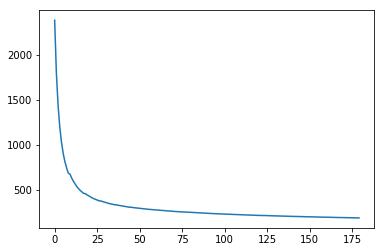

In [56]:
plt.plot(costs)
plt.show()